Import useful libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

%load_ext autoreload
%autoreload 2

In [12]:
import ctypes

lib_path = "/home/matteo/Downloads/ac/build/"

class ACreturn(ctypes.Structure):
	_fields_ = [ ("average", ctypes.c_double), ("sigmaF", ctypes.c_double), ("sigmaF_error", ctypes.c_double), ("ACtime", ctypes.c_double), ("ACtimeError", ctypes.c_double) ]


def ComputeStatistics(data):
	ft_lib = ctypes.cdll.LoadLibrary(lib_path + "libac.so")

	arg = (ctypes.c_double * len(data))(*data)
	avg = ft_lib.Wrapper
	avg.restype = ACreturn

	return avg(arg, len(data))

# Block spin analysis

Specify folders from which to get configurations and set the values of the yukawa couling used in the simulations

In [49]:
################################################################################
# dataset 1
'''folders = ["dataset1/s_0_25/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset1/s_1_0/conf" + str(i+1) for i in range(10)]'''

# dataset 2
'''folders = ["dataset2/s_0_5/conf" + str(i+1) for i in range(10)] 
folders += ["dataset2/s_1_0/conf" + str(i+1) for i in range(10)]'''

# dataset 3
#folders = ["sus/conf" + str(i+1) for i in range(10)]

# dataset 4
#folders = ["s_1_0/conf" + str(i+1) for i in range(10)] 

# dataset 5
folders = ["phase_trans_1/conf" + str(i+1) for i in range(16)] 
#folders  = ["pphase_trans_1/conf" + str(i+1) for i in range(16)]
folders += ["phase_trans_2/conf" + str(i+1) for i in range(16)]
folders += ["phase_trans_4/conf" + str(i+1+16) for i in range(16)]
#folders += ["phase_trans_8/conf" + str(i+1) for i in range(16)] 

Nt0 = 32
Nx0 = 32

colors = ['blue', 'orange', 'green', 'red']
################################################################################

Import functions from Jan Philipp's code

In [14]:
from correlations import *
from read_in_data import *
from mass_fit import *
from mass_matteo import *
from functions import *

In [51]:
def get_chi2xxx(cfgs: np.ndarray, myV):
    """Return mean and error of suceptibility."""
    V = np.prod(cfgs.shape[1:])
    print("dsjfdsomfosdmfodskmfosdkmf" + str(V))
    axis = tuple([i+1 for i in range(len(cfgs.shape)-1)])
    mags = cfgs.mean(axis=axis)
    #return jackknife(V * (mags**2 - mags.mean()**2))
    return jackknife(myV * ((mags - mags.mean())**2))
    #return jackknife(V * (mags**2))

In [18]:
dataset1 = dataset("data1")
dataset1.add_data("phase_trans_1/conf1", ["fermions", "yukawa_coupling"], 1)

FileNotFoundError: [Errno 2] No such file or directory: 'phase_trans_1/conf1/traces.csv'

Load data from specified folders

In [52]:
phi = {}
cond = {}
absphi = {}
chi2 = {}
mr = {}
mqphys = {}
cutoffs = []

for f in folders:
    print(f)
    params = toml.load("data/" + f + "/input.toml") # read toml file with parameters

    s = str(params['physics']['cutFraction']) # read cutoff
    # if cutoff is not already in the list, add it and create the corresponding data arrays
    if not (float(s) in cutoffs):
        cutoffs.append(float(s))
        phi[s] = []
        cond[s] = []
        chi2[s] = []
        mr[s] = []
        mqphys[s] = []

    Nt = int(Nt0 / float(s))
    Nx = int(Nx0 / float(s))
    volume = (Nt, Nx)
    
    p = float(params['physics']['mass']) / float(s) / float(s) # read yukawa coupling
    if p == 0:
        p = 1e-5
    
    print("cutFractions:", s, " mphi2:", p)

    data = read_csv("data/" + f + "/traces.csv") # read file with magnetisation, condensate, ...

    # Get bosonic time slices computed in main.cu
    S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
    # Get fermionic time slices computed in main.cu
    data_Sq_t = read_csv("data/" + f + "/data.csv")
    Sq_t = data_Sq_t['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

    # magnetisation
    blob = ComputeStatistics(data['sigma'])
    val, err = get_abs_mag(data['sigma'].to_numpy()) # !!!!!!!!!!!!!!!!!!!!!!!!! ABSSSSSSSSSSSSSSSSS
    phi[s].append((blob.average, blob.sigmaF, p))
    
    avgxxx = blob.average
    print(blob.average)
    print(blob.sigmaF)
    print(blob.sigmaF_error)
    print(blob.ACtime)
    print(blob.ACtimeError)
    
    # condensate
    val, err = get_mag(data['tr'].to_numpy())
    blob = ComputeStatistics(data['tr'])
    cond[s].append((blob.average, blob.sigmaF, p))
    # susceptibility
    val, err = get_chi2xxx(data['sigma'].to_numpy(), Nx*Nt)
    blob = ComputeStatistics((data['sigma'] - avgxxx)**2)
    chi2[s].append((blob.average, blob.sigmaF, p))
    # renormalised bosonic mass
    val, err = get_ren_mass_right_via_timeslices(S_t,volume)
    mr[s].append((val, err, p))
    # physical quark mass
    val, err = get_phys_quark_mass_via_timeslices(Sq_t,volume)
    print(s, p, blob.average, blob.sigmaF)
    mqphys[s].append((val, err, p))

    
    print()

for k in phi.keys():
    phi[k] = sorted(phi[k], key=lambda x: x[2])
    cond[k] = sorted(cond[k], key=lambda x: x[2])
    chi2[k] = sorted(chi2[k], key=lambda x: x[2])
    mr[k] = sorted(mr[k], key=lambda x: x[2])
    mqphys[k] = sorted(mqphys[k], key=lambda x: x[2])

phase_trans_1/conf1
cutFractions: 1.0  mphi2: -2.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82874.10it/s]


4.896744780904537
0.00015966920491856842
2.5309270452491945e-06
0.5040206341653739
0.014277257598708326


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78154.93it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80536.88it/s]


1.0 -2.0 0.00025161881646958487 3.5277858569354148e-06

phase_trans_1/conf2
cutFractions: 1.0  mphi2: -1.5


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 85002.93it/s]


4.242380765906117
0.00019040050215075874
3.571185389852187e-06
0.5366703271080466
0.018524131214076013


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 84111.98it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82333.75it/s]


1.0 -1.5 0.0003359937565950134 4.767187212364214e-06

phase_trans_1/conf3
cutFractions: 1.0  mphi2: -1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 84132.13it/s]


3.470521397989937
0.00025161944097394824
5.915807007889642e-06
0.6495894832493445
0.02868446068591272


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81230.38it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82583.34it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


1.0 -1.0 0.0004848259297742681 6.945208836933213e-06

phase_trans_1/conf4
cutFractions: 1.0  mphi2: -0.75


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 80007.82it/s]


3.016955059792979
0.0003156190165669861
8.066524876781971e-06
0.770174772111712
0.03696209755245044


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 78638.16it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 81107.67it/s]


1.0 -0.75 0.0006434378773328711 9.744335709838858e-06

phase_trans_1/conf5
cutFractions: 1.0  mphi2: -0.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 85050.81it/s]


2.4923924361809076
0.0004217178678138531
1.1578201230925982e-05
0.9714918535453012
0.049769650805104954


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 84084.50it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 84599.78it/s]


1.0 -0.5 0.000910569792336379 1.4608301713426083e-05

phase_trans_1/conf6
cutFractions: 1.0  mphi2: -0.25


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 82842.29it/s]


1.8674292181690189
0.0006834501988135848
2.422303281766033e-05
1.5610621218076144
0.10351526458390979


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 82273.03it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 84203.06it/s]


1.0 -0.25 0.0014883132677838773 2.638242497505369e-05

phase_trans_1/conf7
cutFractions: 1.0  mphi2: -0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81716.45it/s]


1.4415925075376879
0.0009448018335749266
3.847433828320441e-05
2.189657358433302
0.16608087814743888


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80748.81it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81390.54it/s]


1.0 -0.1 0.0020272523946871252 4.03765726553765e-05

phase_trans_1/conf8
cutFractions: 1.0  mphi2: -0.05


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 73927.10it/s]


1.2980290010050202
0.0010322951314085452
4.3292370155090286e-05
2.4113170738067695
0.18780123449579395


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 73933.12it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 79986.29it/s]


1.0 -0.05 0.0021975396125497415 4.62859062103455e-05

phase_trans_1/conf9
cutFractions: 1.0  mphi2: 0.05


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 83444.95it/s]


1.0290278928643235
0.001139756172013224
5.045656928112004e-05
2.6279191999034035
0.21642866794737564


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81226.27it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81332.17it/s]


1.0 0.05 0.0024579690656232993 5.411358132437224e-05

phase_trans_1/conf10
cutFractions: 1.0  mphi2: 0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82683.14it/s]


0.9114196501507524
0.0011635287172031738
5.1508970753310834e-05
2.6869747137205557
0.22090470596313846


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81475.07it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82872.78it/s]


1.0 0.1 0.0025052438885958877 5.50686533117365e-05

phase_trans_1/conf11
cutFractions: 1.0  mphi2: 0.25


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81690.21it/s]


0.6442272635175875
0.0010100960407821058
4.236138518842201e-05
2.3192915550903646
0.18118399095675147


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81702.85it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81406.73it/s]


1.0 0.25 0.0021875665575582996 4.4880884014635735e-05

phase_trans_1/conf12
cutFractions: 1.0  mphi2: 0.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81431.83it/s]


0.40739724713567993
0.0007113031606883445
2.5211472083749584e-05
1.6163339522611606
0.10691463428660414


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 77551.78it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80887.16it/s]


1.0 0.5 0.0015567923854732987 2.885699997113746e-05

phase_trans_1/conf13
cutFractions: 1.0  mphi2: 0.75


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 85328.37it/s]


0.29251500552708226
0.0005294948671262365
1.6360259725290004e-05
1.1933949727634776
0.06895926387775962


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 83442.83it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 84637.11it/s]


1.0 0.75 0.0011686166081723102 1.946914157373279e-05

phase_trans_1/conf14
cutFractions: 1.0  mphi2: 1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 83623.89it/s]


0.22702974404582507
0.0004233034444305751
1.1621149038043414e-05
0.9712701482157942
0.04975663742019265


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 81718.26it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 80740.83it/s]


1.0 1.0 0.0009177314919496601 1.4315325904558868e-05

phase_trans_1/conf15
cutFractions: 1.0  mphi2: 1.5


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 77973.97it/s]


0.1561695331122488
0.00030402121705280365
7.14746232566227e-06
0.7378340236664263
0.03228178750191752


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 77811.89it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 81019.81it/s]


1.0 1.5 0.0006231914731469912 9.251952704661604e-06

phase_trans_1/conf16
cutFractions: 1.0  mphi2: 2.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 82005.50it/s]


0.1188009411415936
0.00024430167711384204
5.195164960733723e-06
0.61584150225511
0.024334031026097762


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 80787.40it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9951/9951 [00:00<00:00, 80747.08it/s]


1.0 2.0 0.0004821331183241791 6.805879917471871e-06

phase_trans_2/conf1
cutFractions: 0.5  mphi2: -2.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82548.58it/s]


4.891791589104449
0.00022750952695763435
6.6499646223384655e-06
1.060484836942252
0.057998539858358025


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 81048.05it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82498.64it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 -2.0 0.00024274579203701504 3.895294258919765e-06

phase_trans_2/conf2
cutFractions: 0.5  mphi2: -1.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 86361.49it/s]


4.2372591376884445
0.0002964461555470269
9.630058641709116e-06
1.3679149677789038
0.08288244045469143


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78911.26it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82614.07it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 -1.5 0.0003195261827539055 5.642237697283161e-06

phase_trans_2/conf3
cutFractions: 0.5  mphi2: -1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82465.70it/s]


3.4659202573122965
0.0004309442765945564
1.645187506648603e-05
1.9423868770193788
0.13801604086348748


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80252.80it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 85959.86it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 -1.0 0.0004754302553363438 1.0201433968710857e-05

phase_trans_2/conf4
cutFractions: 0.5  mphi2: -0.75


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 85643.54it/s]


3.0126698572864328
0.0005581698588227505
2.4068038897749958e-05
2.4885999297402885
0.19965867948195476


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80424.20it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 79710.53it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 -0.75 0.000622521377748481 1.5019219102312153e-05

phase_trans_2/conf5
cutFractions: 0.5  mphi2: -0.5


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 85726.76it/s]


2.4892283877776626
0.0007968067010304364
4.033976394812393e-05
3.604100391820614
0.33815713593476737


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 75777.73it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82258.76it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 -0.5 0.0008756798371032267 2.541875801323887e-05

phase_trans_2/conf6
cutFractions: 0.5  mphi2: -0.25


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 84135.36it/s]


1.8661932291457317
0.0013294122879954544
8.376193396902155e-05
6.181583726481573
0.7154188620428662


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 83517.09it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80620.27it/s]


0.5 -0.25 0.0014206169868087963 5.467981953042475e-05

phase_trans_2/conf7
cutFractions: 0.5  mphi2: -0.1


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 85684.86it/s]


1.4417560623115602
0.0019140551076376729
0.00014295172112824517
9.292685507699476
1.2665287690362657


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80457.54it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 83826.77it/s]


0.5 -0.1 0.0019577521960322895 9.266360166221091e-05

phase_trans_2/conf8
cutFractions: 0.5  mphi2: -0.05


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82755.12it/s]


1.2985287105527652
0.0020726715802387797
0.0001602792992624467
9.973227605089168
1.4072595317914616


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80443.58it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 83053.54it/s]


0.5 -0.05 0.002138735898890082 0.00010765967147919203

phase_trans_2/conf9
cutFractions: 0.5  mphi2: 0.05


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 76173.36it/s]


1.029297495175875
0.002304538421311918
0.00018554628785666987
11.112235006687346
1.6279488033161362


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 58489.36it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 62005.72it/s]


0.5 0.05 0.0023724708509514835 0.0001257782312561143

phase_trans_2/conf10
cutFractions: 0.5  mphi2: 0.1


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 77683.00it/s]


0.9111869720574963
0.0023199875900978416
0.00018824202945595382
11.19911262065441
1.654730819234618


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 84649.45it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 65857.98it/s]


0.5 0.1 0.0023854540241849704 0.00012573066648950777

phase_trans_2/conf11
cutFractions: 0.5  mphi2: 0.25


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78821.09it/s]


0.6428559214070356
0.0020495933392090247
0.0001571571316501514
9.89107438093614
1.3826744385953367


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 76824.98it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78186.85it/s]


0.5 0.25 0.002108777551759047 0.00010062365267549772

phase_trans_2/conf12
cutFractions: 0.5  mphi2: 0.5


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 79064.19it/s]


0.4057318799879375
0.0014161602501808783
9.255867942508598e-05
6.666094490635181
0.8001268009399887


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 68637.50it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 62498.98it/s]


0.5 0.5 0.0014946012415873644 5.75169417579955e-05

phase_trans_2/conf13
cutFractions: 0.5  mphi2: 0.75


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 62248.65it/s]


0.29115288601869493
0.0010150250943242417
5.7113968916645925e-05
4.62462773630763
0.4807223389545005


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 71242.58it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 60648.40it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 0.75 0.001107196796055558 3.596977254698281e-05

phase_trans_2/conf14
cutFractions: 0.5  mphi2: 1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 63870.04it/s]


0.22595167015075399
0.0007795117915187472
3.8680688066301136e-05
3.4603442115871546
0.318241690028821


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 64853.35it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 59564.41it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 1.0 0.0008730084870672808 2.4372702373079778e-05

phase_trans_2/conf15
cutFractions: 0.5  mphi2: 1.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 76208.69it/s]


0.15548424000000027
0.0005414989425869927
2.270937055479366e-05
2.3992121837640408
0.18693340473714062


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 70836.74it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 63677.09it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 1.5 0.0006077303094162024 1.4017292772769349e-05

phase_trans_2/conf16
cutFractions: 0.5  mphi2: 2.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 68574.45it/s]


0.11815737292190269
0.00041677129232812034
1.591080240550705e-05
1.8437842383784697
0.1315231837912287


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 64009.20it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 67154.82it/s]
/home/matteo/code/QuarkMesonModel/analysis/correlations.py:180: RuntimeWarning: invalid value encountered in sqrt
  ren_mass = np.sqrt( ren_mass2 )


0.5 2.0 0.00046846203273647196 9.565346821509536e-06

phase_trans_4/conf17
cutFractions: 0.25  mphi2: -2.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78033.20it/s]


4.895478700502503
0.00043952284898327195
2.310661156749685e-05
3.9866759436225436
0.3876023535516277


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 77537.22it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 77658.57it/s]


0.25 -2.0 0.00024087893408015188 6.4736716615731745e-06

phase_trans_4/conf18
cutFractions: 0.25  mphi2: -1.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81285.44it/s]


4.241940215075391
0.0005715298021378988
3.3162689490187545e-05
5.072985524106161
0.5423101135428345


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80509.22it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80903.15it/s]


0.25 -1.5 0.00032001262759193426 9.731747803781904e-06

phase_trans_4/conf19
cutFractions: 0.25  mphi2: -1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 83378.88it/s]


3.4724605568398754
0.0008495452295436723
5.8700742538166124e-05
7.603672478391223
0.963008548267579


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 76113.46it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 77093.43it/s]


0.25 -1.0 0.0004714558107865218 1.719478595335431e-05

phase_trans_4/conf20
cutFractions: 0.25  mphi2: -0.75


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 71751.56it/s]


3.0206060991054375
0.0011027214484163707
8.45578709459612e-05
9.747995219645182
1.364745991876964


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 77074.63it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 84111.30it/s]


0.25 -0.75 0.0006193324097001034 2.6335732062274567e-05

phase_trans_4/conf21
cutFractions: 0.25  mphi2: -0.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 77497.48it/s]


2.4996244552763884
0.0015300413563914049
0.0001332800371817913
13.276339660793013
2.0997838333842345


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 76871.25it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81390.70it/s]


0.25 -0.5 0.0008749393093263929 4.372646814618764e-05

phase_trans_4/conf22
cutFractions: 0.25  mphi2: -0.25


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82902.32it/s]


1.8797997708312364
0.0023977978261476075
0.00024808336874042016
20.223201478680267
3.766493302763747


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 81987.08it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 81453.84it/s]


0.25 -0.25 0.001408616072437186 8.99841542825211e-05

phase_trans_4/conf23
cutFractions: 0.25  mphi2: -0.1


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 83525.25it/s]


1.4570604251683572
0.0032269646460766042
0.00037380501603092247
26.798590455657255
5.550566500691332


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 81837.71it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80613.10it/s]


0.25 -0.1 0.0019228323473616978 0.000144639359232127

phase_trans_4/conf24
cutFractions: 0.25  mphi2: -0.05


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 82476.93it/s]


1.3137689216080428
0.0035156544714862363
0.0004222023001103108
29.238657778928168
6.2665072741645


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 79725.61it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 83477.00it/s]


0.25 -0.05 0.0020910290584049054 0.00016456394624322421

phase_trans_4/conf25
cutFractions: 0.25  mphi2: 0.05


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 85311.92it/s]


1.0430783876771497
0.0038704010176762527
0.0004823146923325236
32.00990663103994
7.103545563223095


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 83720.98it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 82528.49it/s]


0.25 0.05 0.0023134389788320173 0.00019377618716203259

phase_trans_4/conf26
cutFractions: 0.25  mphi2: 0.1


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 73705.41it/s]


0.9238851102623398
0.003870213050846003
0.00048072792165785737
31.849638081983514
7.043710282945258


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 71787.24it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 76433.84it/s]


0.25 0.1 0.0023249247274686902 0.00019437486420151716

phase_trans_4/conf27
cutFractions: 0.25  mphi2: 0.25


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 78879.14it/s]


0.6503588741455568
0.003460149096428348
0.00040974534490658543
28.309111232180367
5.985810214651904


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 75215.84it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9948/9948 [00:00<00:00, 79362.84it/s]


0.25 0.25 0.00209198309875678 0.00016325683426751935

phase_trans_4/conf28
cutFractions: 0.25  mphi2: 0.5


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80762.26it/s]


0.4092489639159729
0.0024761690414460153
0.0002561918901893477
20.246910318523682
3.770390824811624


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80029.17it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80724.13it/s]


0.25 0.5 0.0015004350787152557 9.815902461445786e-05

phase_trans_4/conf29
cutFractions: 0.25  mphi2: 0.75


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80692.76it/s]


0.29290032385164283
0.0018736653159325872
0.00017470701993010864
15.710721752075582
2.65045331786186


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 79132.11it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80076.16it/s]


0.25 0.75 0.001108120700704242 6.255941371094999e-05

phase_trans_4/conf30
cutFractions: 0.25  mphi2: 1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80668.89it/s]


0.22696215378429965
0.001505099659861214
0.0001293657205179586
12.833688152346957
2.0043130720659295


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 80213.16it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9949/9949 [00:00<00:00, 74747.89it/s]


0.25 1.0 0.0008758363018671922 4.418885390529267e-05

phase_trans_4/conf31
cutFractions: 0.25  mphi2: 1.5


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81265.18it/s]


0.15591201249246286
0.0010583239293509908
7.904120764770074e-05
9.100016399038916
1.242852367056082


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 78497.45it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 81039.52it/s]


0.25 1.5 0.0006112259798311501 2.5438587710542256e-05

phase_trans_4/conf32
cutFractions: 0.25  mphi2: 2.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80493.70it/s]


0.11857538074371834
0.0008275506083870659
5.596141925636031e-05
7.322138717906216
0.9071147012449364


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80963.74it/s]


dsjfdsomfosdmfodskmfosdkmf1.0


100%|████████████████████████████████████| 9950/9950 [00:00<00:00, 80411.96it/s]


0.25 2.0 0.00046463337148597213 1.6854748289472786e-05



In [53]:
'''IMPORTANT: should I use the one for large t, small t or the whole? 
tmp_ren = []
tmp_large_t = []
tmp_small_t = []

S_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")
tmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)
tmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)
tmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)

ren_masses = tmp_ren
print("ren mass:", val, err)'''

'IMPORTANT: should I use the one for large t, small t or the whole? \ntmp_ren = []\ntmp_large_t = []\ntmp_small_t = []\n\nS_t = get_time_slices_from_timeslicefile("data/sim1/slice.dat")\ntmp_ren = get_ren_mass_right_via_timeslices(S_t,volume)\ntmp_large_ = get_masses_from_large_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\ntmp_small_t = get_masses_from_small_t(S_t, volume, [0,0,0,0],inc_in_fit=3, with_plot = False)\n\nren_masses = tmp_ren\nprint("ren mass:", val, err)'

# Plot Stuff

### Plot of the magnetization

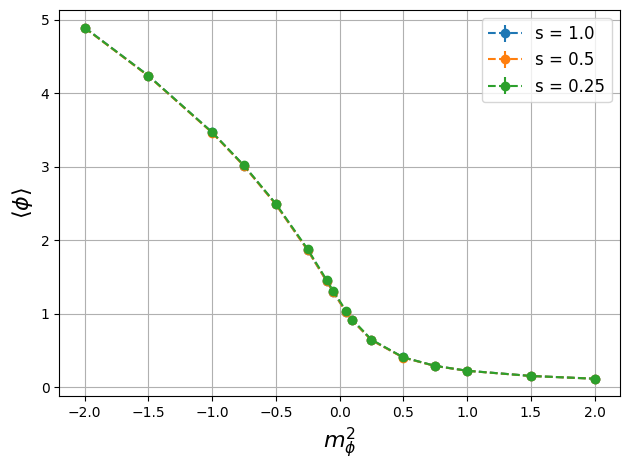

In [54]:
for k in phi.keys():
    plt.errorbar([v[2] for v in phi[k]], [v[0] for v in phi[k]], [v[1] for v in phi[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$\left\langle \phi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("phi.pdf")
plt.show()

### Plot of the magnetic susceptibility

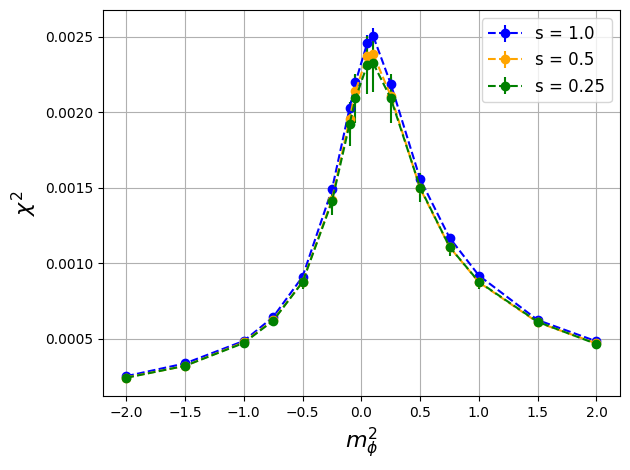

In [55]:
for k, c in zip(chi2.keys(), colors):
    xvals = [v[2] for v in chi2[k]]
    yvals = [v[0] for v in chi2[k]]
    errs = [v[1] for v in chi2[k]]
    plt.errorbar(xvals, yvals, errs, fmt='o--', label='s = ' + str(k), color=c)
    #plt.plot([xvals[yvals.index(max(yvals))], xvals[yvals.index(max(yvals))]], [min(yvals), max(yvals)], '--', color=c)

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$\chi^2$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("chi2.pdf")
plt.show()

### Plot of the condensate

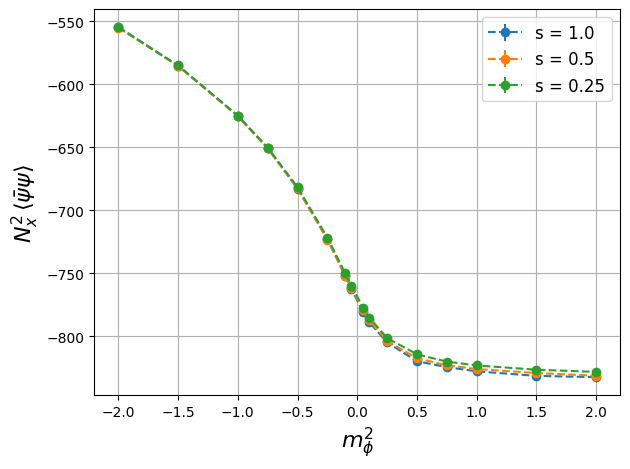

In [56]:
for k in cond.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in cond[k]], [Nx*Nx*v[0] for v in cond[k]], [Nx*Nx*v[1] for v in cond[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$N_x^2 \, \left\langle \bar \psi \psi \right\rangle$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("condensate.pdf")
plt.show()

### Plot of the physical quark mass

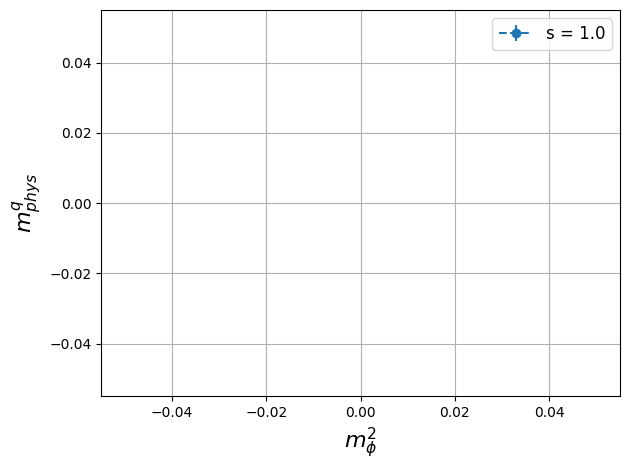

In [48]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mqphys[k]], [v[0] for v in mqphys[k]], [0 for _ in range(len(mqphys[k]))], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
#plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$m^q_{phys}$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("mqphys.pdf")
plt.show()

### Plot of the bosonic renormalised mass

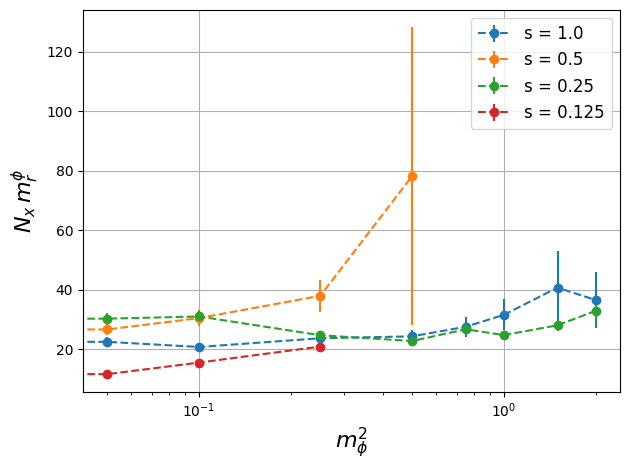

In [24]:
for k in mr.keys():
    Nx = Nx0/float(k)
    plt.errorbar([v[2] for v in mr[k]], [Nx*v[0] for v in mr[k]], [Nx*v[1] for v in mr[k]], fmt='o--', label='s = ' + str(k))

plt.legend(fontsize=12)
plt.xscale('log')
plt.xlabel(r'$m_\phi^2$', fontsize=16)
plt.ylabel(r'$N_x \, m^\phi_r$', fontsize=16)
plt.tight_layout()
plt.grid()
plt.savefig("mphir.pdf")
plt.show()

# Physical quark mass

In [25]:
from scipy.optimize import curve_fit as fit

####################################################
data_folder = "dataset2/s_1_0/conf1"
Nt = 16
plot = True
####################################################

def fitfuncSinh(x, m_re, A):
    return A * np.sinh(m_re*(Nt/2-x))

def fitToSinh(ydata, startidx, endidx, plot=False):
    yvals = ydata[startidx:endidx]
    xvals = np.array(range(startidx, endidx))

    fitparams = fit(fitfuncSinh, xvals, yvals, p0=[1e-2, 0])
    #print("Mass: ", abs(fitparams[0][0]))
        
    return fitparams[0]

params = toml.load("data/" + data_folder + "/input.toml") # read toml file with parameters
s = params['physics']['cutFraction'] # read cutoff
g = params['fermions']['yukawa_coupling']

data = read_csv("data/" + data_folder + "/data.csv")
timeslices = data['corr'].to_numpy(np.dtype('f8')).reshape((-1, Nt))

corr = np.average(timeslices, axis=0)

fitparams = fitToSinh(corr, 1, Nt, plot)

print("s:", s, " g:", g)
print("Number of data points:", timeslices.shape[0])
print("Nt:", Nt)
print("Mass =", fitparams[0])

s: 1.0  g: 0.0
Number of data points: 9951
Nt: 16
Mass = 0.18232309093929663


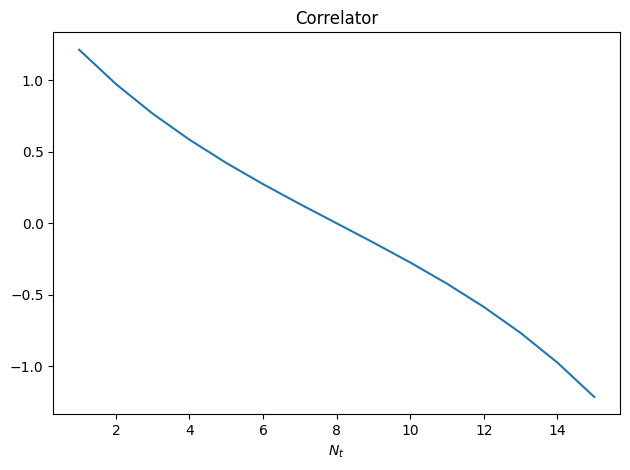

In [18]:
plt.plot(range(1, Nt), corr[1:Nt])
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

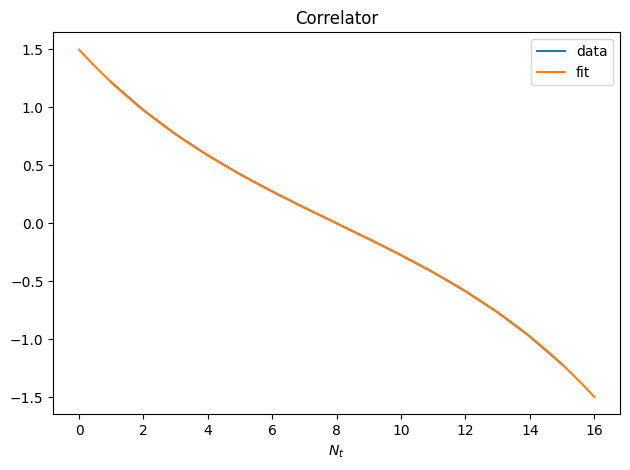

In [19]:
plt.plot(range(1, Nt), corr[1:Nt], label="data")
xvals = np.linspace(0, Nt, 1000)
plt.plot(xvals, fitfuncSinh(xvals, fitparams[0], fitparams[1]), label='fit')
plt.legend()
plt.xlabel(r'$N_t$')
plt.title("Correlator")
plt.tight_layout()
plt.savefig("mass.pdf")
plt.show()

Compute expected mass from background fields

In [20]:
def expectedM(m0, g, sigma, pi):
    r2 = sigma**2 + pi[0]**2 + pi[1]**2 + pi[2]**2
    denom = 2*(g*sigma + m0 + 1)
    sqrroot = np.sqrt((g**2*r2 + 2*m0*(g*sigma + 1) + 2*g*sigma + m0**2 + 2)**2 - 4*(g*sigma+m0+1)**2)
    num = -sqrroot + g**2*r2 + 2*g*m0*sigma + 2*g*sigma + m0**2 + 2*m0 + 2
    return -np.log(num/denom)

mq0 = 0.2
yukawa_coupling = 0.1
sigma = 0.16
pi = [0, 0, 0]

print("Expected mass with phi =", np.concatenate(([sigma], pi)), ":", expectedM(mq0, yukawa_coupling, sigma, pi))

Expected mass with phi = [0.16 0.   0.   0.  ] : 0.1955667835439752


# Renormalised boson mass

In [21]:
from correlations import *
from read_in_data import *
from mass_fit import *

In [ ]:
####################################################
f = "dataset1/s_1_0/conf1"
Nt = 16
Nx = 16
####################################################
volume = (Nt, Nx)

In [ ]:
S_t = get_time_slices_from_timeslicefile("data/" + f + "/slice.dat", field_axis=0, return_all=False)
val, err = get_phys_quark_mass_via_timeslices(S_t,volume)
print("mr:", val, err)

# Mean Field equations of motion

Reset data arrays

In [ ]:
sigma_vals = []
sigma_errs = []
tr_vals = []
tr_errs = []
cutFractions = []

In [39]:
rcParams['text.usetex'] = True

####################################################
folders = ["s1"]
mypath = "data/"
plot_trace = True
####################################################


c = 0
for fold in folders:
    s = []
    data = [] # each element will be a triple (s, sigma, err_sigma)
    data_trace = [] # each element will be a triple (s, condensate, err_condensate)
    for f in os.listdir(mypath + fold):
        
        full_path = mypath + fold + "/" + f + "/"   
        
        params = toml.load(full_path + "/input.toml")
        s = float(params['physics']['cutFraction'])
       
        filedata = read_csv(full_path + "traces.csv")
        N = len(filedata['sigma'])
    
        # vals
        sigma = np.average(filedata['sigma'].to_numpy())
        tr = np.average(filedata['tr'].to_numpy())
        
        print("s =", s, " <|sigma|> = ", sigma, " <|psibar psi|> = ", tr)
        
        # errs
        sigma_err = np.std(filedata['sigma'].to_numpy()) / np.sqrt(N-1)
        tr_err = np.std(filedata['tr'].to_numpy()) / np.sqrt(N-1)
                    
        data.append((s, sigma, sigma_err))
        data_trace.append((s, tr, tr_err))
    
    data = sorted(data, key=lambda x: x[0])
    data_trace = sorted(data_trace, key=lambda x: x[0])
                    
    for el in data:
        cutFractions.append(el[0])
        sigma_vals.append(el[1])
        sigma_errs.append(el[2])
    
    for el in data_trace:
        tr_vals.append(el[1])
        tr_errs.append(el[2])

    plt.errorbar(cutFractions, sigma_vals, yerr=sigma_errs, fmt='o', color=colors[c])
    if plot_trace:
        plt.errorbar(cutFractions, [t/1 for t in tr_vals], yerr=[t/1 for t in tr_errs], fmt='o')

    c += 1
                    
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'data/s1'